In [1]:
import pyextractMS
from matplotlib import pylab as plt
from matplotlib import rcParams
import numpy as np
import MSFileReader
from matplotlib import cm
from os import path
import time

SAVEFIG=False
FIG_EXTENSION='.png'
colors = cm.get_cmap(name='plasma')

In [2]:
def set_style_single_inj():
    rcParams['axes.labelsize'] = 9
    rcParams['xtick.labelsize'] = 8
    rcParams['ytick.labelsize'] = 8
    rcParams['legend.fontsize'] = 8
    rcParams['grid.alpha'] = 0.5
    rcParams['grid.color'] = "grey"
    rcParams['axes.formatter.limits'] = [-4,4]
    
    figsize = (8,10)    
    fig = plt.figure(constrained_layout=True, figsize=figsize)
    gs = fig.add_gridspec(ncols=2, nrows=5)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    ax4 = fig.add_subplot(gs[2, 0])
    ax5 = fig.add_subplot(gs[2, 1])
    ax6 = fig.add_subplot(gs[3, 0])
    ax7 = fig.add_subplot(gs[3, 1])
    ax8 = fig.add_subplot(gs[4, :])
    return [fig, [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]]

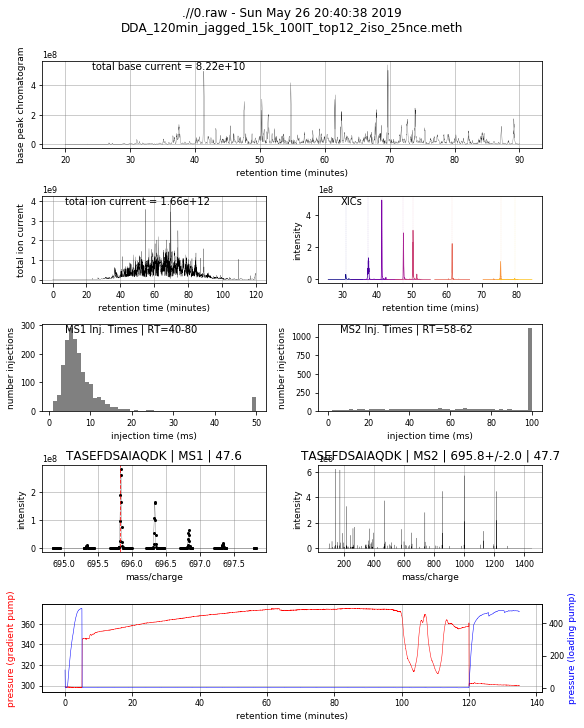

In [11]:
fig,axes = set_style_single_inj()
file_name = './/0.raw'
rawfile = MSFileReader.ThermoRawfile(file_name)
title = file_name + ' - ' + time.ctime(path.getmtime(file_name)) + '\n' + rawfile.GetSeqRowInstrumentMethod().split('\\')[-1]
fig.suptitle(title)
pyextractMS.plot_bpc(rawfile, fig_axis=axes[0], rt_range=[20,90])
pyextractMS.plot_tic(rawfile, fig_axis=axes[1])
pyextractMS.plot_xics(rawfile, fig_axis=axes[2])
pyextractMS.plot_inj_times(rawfile, 1, fig_axis=axes[3], rt_range=[40,80])
pyextractMS.plot_inj_times(rawfile, 2, fig_axis=axes[4], rt_range=[58,62])

##### iRT peptide of interest 3###
#'TASEFDSAIAQDK':[695.8324,46.75]#
##################################
ms1_peptide = 'TASEFDSAIAQDK'
ms1_charge = 2
ms1_mz = 695.8324
ms1_rt = 46.75
ms1_mass_accuracy=0.01
ms1_rt_window=5
rt_range  =ms1_rt-ms1_rt_window, ms1_rt+ms1_rt_window

full_xic = pyextractMS.get_xic(rawfile, rt_range=rt_range,
                               mz_range=[ms1_mz-ms1_mass_accuracy,ms1_mz+ms1_mass_accuracy])
ms1_peak_max_rt, ms1_peak_max_intensity = pyextractMS.get_max_rt(full_xic)
ms1_peak_max_scan = rawfile.ScanNumFromRT(ms1_peak_max_rt)
ms1_peak_max_rt = round(ms1_peak_max_rt, 1)
ms1_mz_range = pyextractMS.calc_mz_range(ms1_peptide, ms1_mz, labeling='None', charge=2, offset=2)

ms1 = pyextractMS.extract_ms_spectra(rawfile, ms1_peak_max_scan, ms1_mz_range)
pyextractMS.plot_ms_spectra(ms1, title=ms1_peptide+' | MS1 | '+str(ms1_peak_max_rt), fig_axis=axes[5])
axes[5].axvline(ms1_mz, linestyle='--', color='red', alpha=0.75, linewidth=1)

#plot iRT MS2 @max
relevant_ms2_scans = pyextractMS.get_ms2_scans(rawfile, ms1_mz, rt_range = rt_range)
nearest_ms2_scan = pyextractMS.find_nearest(relevant_ms2_scans, ms1_peak_max_scan)
ms2 = pyextractMS.extract_ms_spectra(rawfile, nearest_ms2_scan)
ms2_rt = str(round(rawfile.RTFromScanNum(nearest_ms2_scan), 1))
ms2_scan = rawfile.GetTrailerExtraForScanNum(nearest_ms2_scan)
ms2_iso = str(round(ms2_scan['Monoisotopic M/Z'], 1))
ms2_width = str(ms2_scan['MS2 Isolation Width'])
pyextractMS.plot_ms_spectra(ms2, title=ms1_peptide+' | MS2 | '+ ms2_iso +'+/-'+ms2_width + ' | ' + ms2_rt, 
                            fig_axis=axes[6], circle_size=0)
pyextractMS.plot_pressure_traces(rawfile, fig_axis=axes[7])
if SAVEFIG:
    fig.savefig('.//test.pdf')